In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import torch
import numpy as np
import matplotlib.pyplot as plt
from balanced_loss import Loss
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModel
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

from data.constants import LOCAL_MODELS_PATH, CHECKPOINTS_PATH, DATASET_PATH

df = pd.read_parquet(DATASET_PATH)
df = df.iloc[:5000, :]

BASE_MODEL_PATH = LOCAL_MODELS_PATH / 't5-small'
MAX_LEN = 512
batch_size = 10
TRAIN_BATCH_SIZE = batch_size
VALID_BATCH_SIZE = batch_size
TEST_BATCH_SIZE = batch_size

LIMIT_NUM_MODELS = 2

SEED = 2
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 2e-5
N_EPOCHS = 10
PATIENCE = 3

model_name = BASE_MODEL_PATH.name
CHECKPOINTS_DIR = CHECKPOINTS_PATH / model_name / 'checkpoints'
CHECKPOINTS_DIR.mkdir(exist_ok=True, parents=True)
MODEL_TO_SAVE_TEMPLE = 'model-{epoch}-epoch.pt'

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      5000 non-null   object 
 1   Drug_ID    5000 non-null   object 
 2   Drug       5000 non-null   object 
 3   Target_ID  5000 non-null   object 
 4   Target     5000 non-null   object 
 5   Y          5000 non-null   float32
dtypes: float32(1), object(5)
memory usage: 215.0+ KB


In [3]:
# Проверка доступности GPU
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))

# Указание устройства
DEVICE = torch.device("cuda:0")  # Используем первую видеокарту (индекс 0)

CUDA Available: True
Number of GPUs: 1
Current GPU: NVIDIA GeForce GTX 1650


In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train, df_valid = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [5]:
class ProteinSeqSmailesDataset(Dataset):
    def __init__(self, df, tokenizer_path, input_column, output_column, max_len):
        self.max_len = max_len
        self.df = df
        self.input_column = input_column
        self.output_column = output_column
        self.tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]

        inputs = self.tokenizer.encode_plus(
            row[self.input_column],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )

        labels = self.tokenizer.encode_plus(
            row[self.output_column],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
    
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': labels['input_ids'].flatten(),
        }

train_dataset = ProteinSeqSmailesDataset(df_train, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)
valid_dataset = ProteinSeqSmailesDataset(df_valid, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)
test_dataset = ProteinSeqSmailesDataset(df_test, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
train_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, generator=torch.manual_seed(SEED), num_workers=0, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, generator=torch.manual_seed(SEED), num_workers=0, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, generator=torch.manual_seed(SEED), num_workers=0, shuffle=True, pin_memory=True)

In [8]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_PATH)
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

In [9]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.9,
    patience=2,
    )

In [10]:
loss_status = {
    'train': [],
    'valid': []
}
min_valid_loss = float('inf')
epochs_without_improvement = 0
saved_models_path = []

In [11]:
for epoch in range(N_EPOCHS):
    train_losses = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader, 'Train')):
        optimizer.zero_grad()

        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        labels = batch['labels']
        del batch['labels']

        outputs = model(**batch, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    valid_losses = []
    model.eval
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader, 'Valid')):
            batch = {key: value.to(DEVICE) for key, value in batch.items()}
            labels = batch['labels']
            del batch['labels']

            outputs = model(**batch, labels=labels)
            loss = outputs.loss

            valid_losses.append(loss.item())
    
    loss_status['train'].append(np.mean(train_losses))
    loss_status['valid'].append(np.mean(valid_losses))

    scheduler.step(loss_status['valid'][-1])

    if loss_status["valid"][-1] < min_valid_loss:
        min_valid_loss = loss_status["valid"][-1]
        epochs_without_improvement = 0

        model_name = CHECKPOINTS_DIR / MODEL_TO_SAVE_TEMPLE.format(epoch=epoch)
        torch.save(model.state_dict(), str(model_name))

        saved_models_path.append(model_name)
        if len(saved_models_path) > LIMIT_NUM_MODELS:
            model_to_del = saved_models_path[0]
            model_to_del.unlink()
            del saved_models_path[0]
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break


    print(f"{'EPOCH: ' + str(epoch):-^50}")
    print(f"Loss:")
    print(f"  Train: {loss_status['train'][-1]:.5f}")
    print(f"  Valid: {loss_status['valid'][-1]:.5f}")
    print("-" * 50, end="\n\n")


Valid: 100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


---------------------EPOCH: 0---------------------
Loss:
  Train: 1.31538
  Valid: 0.47511
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


---------------------EPOCH: 1---------------------
Loss:
  Train: 0.38385
  Valid: 0.34113
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


---------------------EPOCH: 2---------------------
Loss:
  Train: 0.29996
  Valid: 0.28189
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


---------------------EPOCH: 3---------------------
Loss:
  Train: 0.25348
  Valid: 0.24429
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:58<00:00,  2.36s/it]


---------------------EPOCH: 4---------------------
Loss:
  Train: 0.22513
  Valid: 0.22207
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


---------------------EPOCH: 5---------------------
Loss:
  Train: 0.20724
  Valid: 0.20660
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


---------------------EPOCH: 6---------------------
Loss:
  Train: 0.19421
  Valid: 0.19359
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]


---------------------EPOCH: 7---------------------
Loss:
  Train: 0.18290
  Valid: 0.18350
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


---------------------EPOCH: 8---------------------
Loss:
  Train: 0.17417
  Valid: 0.17631
--------------------------------------------------



Valid: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]


---------------------EPOCH: 9---------------------
Loss:
  Train: 0.16689
  Valid: 0.16801
--------------------------------------------------



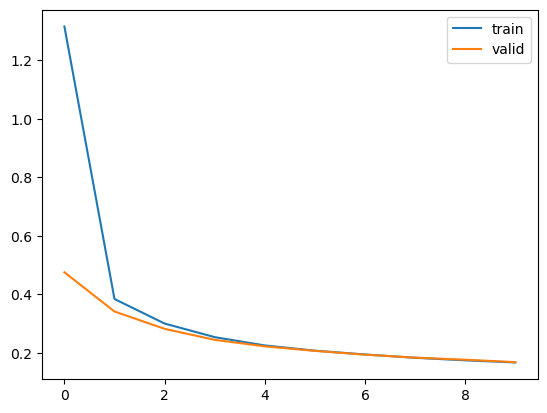

In [12]:
plt.plot(loss_status['train'], label='train')
plt.plot(loss_status['valid'], label='valid')
plt.legend()
plt.show()


In [13]:
def evaluate_test_loss(model, data_loader, device):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for batch in tqdm(data_loader, "Test"):
            batch = {key: value.to(device) for key, value in batch.items()}
            labels = batch["labels"]
            del batch["labels"]

            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            test_losses.append(loss.item())

    return np.mean(test_losses)

# Вычисление потерь на тестовом наборе
test_loss = evaluate_test_loss(model, test_loader, DEVICE)
print(f"Test Loss: {test_loss:.4f}")

Test: 100%|██████████| 100/100 [05:58<00:00,  3.58s/it]

Test Loss: 0.1369


# Промедуточные выводы:
Было проведено обучение модели на 10 эпохах. Однако, судя по графику потерь (loss) и значениям train_loss и valid_loss, модель продолжает улучшаться, хотя темпы улучшения замедляются. Это означает, что можно продолжить обучение для достижения лучших результатов.

 • Validation Loss:  Последнее значение valid_loss = 0.16801.
 • Train Loss:  Последнее значение train_loss = 0.16689.

Разница между train_loss и valid_loss минимальна, что указывает на отсутствие переобучения.
Вывод:  Модель еще не достигла своего предела, и можно продолжить обучение.

Поскольку модель уже прошла несколько эпох, дальнейшее обучение с той же скоростью может привести к "перескакиванию" через минимум функции потерь. Рекомендуется уменьшить скорость обучения.


## План дальше:
Сначала дообчуить 5 этох модель на текущих данных, чтобы достичь плато, а затем добавить новую порцию данных.

In [ ]:
model.load_state_dict(torch.load(saved_models_path[-1]))

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE / 10)

MODEL_TO_SAVE_TEMPLE = 'continue-model-{epoch}-epoch.pt'
N_EPOCHS_CONTINUE = 5
for epoch in range(N_EPOCHS_CONTINUE):
    train_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_loader, 'Train')):
        optimizer.zero_grad()
        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        labels = batch['labels']
        del batch['labels']
        outputs = model(**batch, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader, 'Valid')):
            batch = {key: value.to(DEVICE) for key, value in batch.items()}
            labels = batch['labels']
            del batch['labels']
            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            valid_losses.append(loss.item())
    
    loss_status['train'].append(np.mean(train_losses))
    loss_status['valid'].append(np.mean(valid_losses))
    scheduler.step(loss_status['valid'][-1])
    
    if loss_status["valid"][-1] < min_valid_loss:
        min_valid_loss = loss_status["valid"][-1]
        epochs_without_improvement = 0
        model_name = CHECKPOINTS_DIR / MODEL_TO_SAVE_TEMPLE.format(epoch=epoch + N_EPOCHS)
        torch.save(model.state_dict(), str(model_name))
        saved_models_path.append(model_name)
        if len(saved_models_path) > LIMIT_NUM_MODELS:
            model_to_del = saved_models_path[0]
            model_to_del.unlink()
            del saved_models_path[0]
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break
    
    print(f"{'EPOCH: ' + str(epoch + N_EPOCHS):-^50}")
    print(f"Loss:")
    print(f"  Train: {loss_status['train'][-1]:.5f}")
    print(f"  Valid: {loss_status['valid'][-1]:.5f}")
    print("-" * 50)


Train:   0%|          | 1/450 [00:43<5:29:00, 43.97s/it]